# Dynamometer Card Analysis

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Hydraulic_dynamometer_%28Rankin_Kennedy%2C_Modern_Engines%2C_Vol_VI%29.jpg/1024px-Hydraulic_dynamometer_%28Rankin_Kennedy%2C_Modern_Engines%2C_Vol_VI%29.jpg">

https://en.wikipedia.org/wiki/Dynamometer

'The most popular elevation mechanism used in the oil industry is the âRod Pump Systemâ, which is basically composed by three elements: the âPumping Unitâ; the âSucker Rodâ and the âPumpâ itself. The main diagnostic measure tool is the âDownhole Dynamometer Cardâ which is formed by the values of position of the pumping unit and the pressure in the connection junction of the sucker rod and the pump.

The use of an automatic system for pattern recognition of downhole dynamometer cards allows anticipating the problems with its earlier identification and therefore to take both corrective and prevention measures for it.' http://webx.ubi.pt/~felippe/paper/paper2009_milano.pdf

This excercise uses PCA to reduce the dimensionality of dynamometer card plots for later use in clustering, classification and regression

# Connect to datasource in AML.  See Documentation

# Import Python Libraries

In [1]:
'''
Imports
'''
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from datetime import datetime
from collections import defaultdict

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import seaborn

%matplotlib inline

# Read data into Pandas DataFrame
##Load the Dynamometer Card Raw Dataset into Python

In [3]:
from azureml import Workspace
ws = Workspace(
    workspace_id='42ee527dd34148f08273ad67b4654a49',
    authorization_token='',
    endpoint='https://studioapi.azureml.net'
)
experiment = ws.experiments['42ee527dd34148f08273ad67b4654a49.f-id.8012a2b15436439180e3fa1ec54e9307']

# raw model data - Dynamometer Card Reading Data Raw

ds = experiment.get_intermediate_dataset(
    node_id='d572de49-2574-4225-82e4-eb638c102f31-27572',
    port_name='Results dataset',
    data_type_id='GenericCSV'
)

In [4]:
mydata=ds.to_dataframe()

## Load the Dynamometer Clusters Dataset into Python

In [78]:
from azureml import Workspace
ws = Workspace(
    workspace_id='42ee527dd34148f08273ad67b4654a49',
    authorization_token='',
    endpoint='https://studioapi.azureml.net'
)
experiment = ws.experiments['42ee527dd34148f08273ad67b4654a49.f-id.8012a2b15436439180e3fa1ec54e9307']
ds = experiment.get_intermediate_dataset(
    node_id='d572de49-2574-4225-82e4-eb638c102f31-27631',
    port_name='Results dataset',
    data_type_id='GenericCSV'
)

In [79]:
clusters = ds.to_dataframe()

# What are the dimensions of my data?

In [8]:
mydata.shape

(3472980, 5)

# What does my data look like?

Obtain the first several rows of a matrix or data frame using head, and use tail to obtain the last several rows. These functions may also be applied to obtain the first or last values in a vector.

mydata.head(n=6)  
mydata Ã¢ÂÂ A data frame.  
n Ã¢ÂÂ The first n rows (or values if x is a vector) will be returned.

mydata.tail(n=6)  
x Ã¢ÂÂ A matrix, data frame, or vector.  
n Ã¢ÂÂ The last n rows (or values if x is a vector) will be returned.

In [9]:
mydata.head()

,well,date,idx,x,y
0,Alabama,8/16/2013 1:55:22 AM,1,0.000740,-5327.236980
1,Alabama,8/16/2013 1:55:22 AM,2,0.155958,-4476.758361
2,Alabama,8/16/2013 1:55:22 AM,3,1.536036,-3475.778052
3,Alabama,8/16/2013 1:55:22 AM,4,3.779102,-2636.548613
4,Alabama,8/16/2013 1:55:22 AM,5,6.817062,-1999.545532


Here we have 5 variables

well is the name of the well  
date is the date the measurement was taken  
idx is the sample number for that well and date  
x and y are the position and load of the dynamometer at each sample  

If we plot all of the samples for a given well on a given date, we should get a graph that looks like the loop below:

<img src="http://www.scielo.org.co/img/revistas/iei/v34n3/v34n3a02f4.jpg">

In [10]:
mydata.head()

,well,date,idx,x,y
0,Alabama,8/16/2013 1:55:22 AM,1,0.000740,-5327.236980
1,Alabama,8/16/2013 1:55:22 AM,2,0.155958,-4476.758361
2,Alabama,8/16/2013 1:55:22 AM,3,1.536036,-3475.778052
3,Alabama,8/16/2013 1:55:22 AM,4,3.779102,-2636.548613
4,Alabama,8/16/2013 1:55:22 AM,5,6.817062,-1999.545532


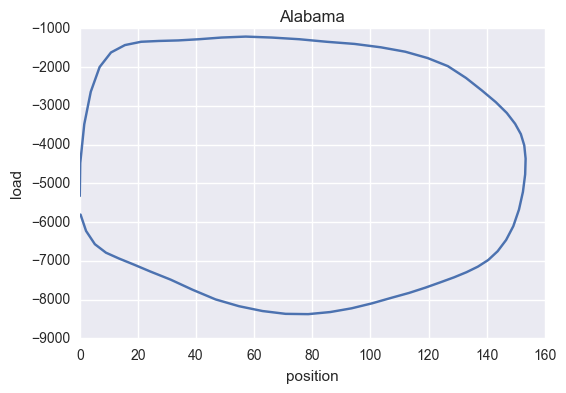

In [11]:
'''
Let us plot one dynamoter plot and see what it looks like
'''

d = '8/16/2013 1:55:22 AM'
well = 'Alabama'
AL = mydata[(mydata.well == well) & (mydata.date == d)]
plt.plot(AL.x, AL.y)
plt.title('Alabama')
plt.xlabel('position')
plt.ylabel('load')

## Good enough for educational purposes.  This data was synthesized based on statistics from real dynamometer cards

# What types of data do I have?

While doing programming in any programming language, you need to use various variables to store various information. Variables are nothing but reserved memory locations to store values. This means that, when you create a variable you reserve some space in memory.

You may like to store information of various data types like character, wide character, integer, floating point, double floating point, Boolean etc. Based on the data type of a variable, the operating system allocates memory and decides what can be stored in the reserved memory.

Read more at: https://docs.python.org/2/library/datatypes.html

In [12]:
mydata.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472980 entries, 0 to 3472979
Data columns (total 5 columns):
well    3472980 non-null object
date    3472980 non-null object
idx     3472980 non-null int64
x       3472980 non-null float64
y       3472980 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 132.5+ MB


# Questions:

Do these data types look right?  We can already see from the mydata.head() that we have dates, but it is of the class "object".  We should convert it to a numeric type, specifically a time type.  Let's not destroy anything so we'll create a new column for the converted data type.

In [13]:
mydata.date.head()

0    8/16/2013 1:55:22 AM
1    8/16/2013 1:55:22 AM
2    8/16/2013 1:55:22 AM
3    8/16/2013 1:55:22 AM
4    8/16/2013 1:55:22 AM
Name: date, dtype: object

## Data Engineering

Convert string format 'date' to a datetime type

In [14]:
mydata['date_date'] = [datetime.strptime(dt,'%m/%d/%Y %I:%M:%S %p' ) for dt in mydata.date]

In [15]:
mydata.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3472980 entries, 0 to 3472979
Data columns (total 6 columns):
well         3472980 non-null object
date         3472980 non-null object
idx          3472980 non-null int64
x            3472980 non-null float64
y            3472980 non-null float64
date_date    3472980 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 159.0+ MB


## Question: Why bother converting the string to a datetime?

# Descriptive Stats

Pandas gives us some useful methods for summarizing or describing our data.  Try the following

In [16]:
mydata.describe()

,idx,x,y
count,3.472980e+06,3.472980e+06,3.472980e+06
mean,3.050000e+01,7.421561e+01,-1.832019e+03
std,1.731810e+01,5.326694e+01,3.920566e+03
min,1.000000e+00,-3.507782e+01,-2.999461e+04
25%,1.575000e+01,2.049056e+01,-4.567489e+03
50%,3.050000e+01,7.670937e+01,-1.715466e+03
75%,4.525000e+01,1.208553e+02,6.920793e+02
max,6.000000e+01,5.232050e+02,2.783662e+04


In [17]:
'''The date is missing so let us specify it explicitly by setting the include variable'''
mydata.describe(include=['object','float64', 'datetime64[ns]'])

,well,date,x,y,date_date
count,3472980,3472980,3.472980e+06,3.472980e+06,3472980
unique,263,57853,NaN,NaN,57853
top,Landon,1/31/2015 8:11:02 AM,NaN,NaN,2013-12-30 12:14:03
freq,40620,120,NaN,NaN,120
first,NaN,NaN,NaN,NaN,2013-03-01 21:18:48
last,NaN,NaN,NaN,NaN,2024-10-04 05:16:23
mean,NaN,NaN,7.421561e+01,-1.832019e+03,NaN
std,NaN,NaN,5.326694e+01,3.920566e+03,NaN
min,NaN,NaN,-3.507782e+01,-2.999461e+04,NaN
25%,NaN,NaN,2.049056e+01,-4.567489e+03,NaN


# Question:

1.  Over what time span does our data exist?
2.  What are typical values of x,y, idx?  
3.  How many unique wells are we talking about?
4.  How many unique dates?
5.  What kinds of data do we have?
6.  Are these values reasonable?

Thoughts: Categorical Variables (Nominal Data): Some variables may be better treated as categorical if they don't have numeric properties.  For example, if we were seeing menu items, item 10 is not twice as great as item 5.  If were to treat menu items as numeric variables in a predictive model we could get strange results.  it's a judgement call.  Columns with fewer unique values might be treated as categorical variables and the unique values then become levels.  

Ordinal Data: Columns with fewer unique numeric values may be part of a numeric sequence and we may treat them as ordinals e.g. 1st, 2nd, 3rd...  If this is the case we may choose to reshape our data so that 1st, 2nd, 3rd become their own columns!  Each sample would then have its own set of ordinal positions. 

A classic example are binary values.  If we see two unique values in a columns it very well could be a true/false or yes/no variable.

If we see a variable with one unique value and our dataset will never grow, we can disregard it completely since it doesn't differentiate samples

# What did we learn?

Do we have any categorical, cardinal, ordinal, or ordinal data?

## Let's take a look at the unique values of well, date

In [18]:
np.unique(mydata.idx)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60], dtype=int64)

In [19]:
np.unique(mydata.well)

array([u'Alabama', u'Alaska', u'Alvin', u'Arizona', u'Arkansas', u'Asia',
       u'Audi', u'Bagel', u'Balou', u'Barclay', u'Barney', u'Beck',
       u'Bellatrix', u'Bianca', u'Biloxi', u'Birdie', u'Biscuit',
       u'Blanca', u'Bobbafett', u'Bodie', u'Bono', u'Booboo', u'Bootsie',
       u'Bordeaux', u'Brandy', u'Bren', u'Bronco', u'Bruin', u'Bubbles',
       u'Buffy', u'Burt', u'Butler', u'Button', u'California', u'Calvin',
       u'Candy', u'Carter', u'Cece', u'Cessa', u'Chandler', u'Chaucer',
       u'Chevy', u'China', u'Choochoo', u'Cisco', u'Claire', u'Cleopatra',
       u'Clooney', u'Coco(nut)', u'Colorado', u'Connecticut', u'Connor',
       u'Cosmo', u'Crosby', u'Cupcake', u'Daisy', u'Dallas', u'Daphne',
       u'Delaware', u'Delilah', u'Diva', u'Doc', u'Domino', u'Donna',
       u'Donovan', u'Dulus', u'Dutch', u'Ebony', u'Ed', u'Elton',
       u'Elwood', u'Ernie', u'Faith', u'Faya', u'Felix', u'Fig', u'Fiona',
       u'Florida', u'Foxy', u'Fritz', u'Fuse', u'Georgia', u'Giblet'

# Let's treat well and date as factors and look at load and position

In [20]:
well_dates = mydata.groupby(['well','date_date'])

In [21]:
well_means = well_dates.mean()
well_means.reset_index(inplace = True)
well_means.head()

,well,date_date,idx,x,y
0,Alabama,2013-08-16 01:55:22,30.5,80.940701,-4833.330713
1,Alabama,2013-08-16 23:49:23,30.5,80.940701,-4833.330713
2,Alabama,2013-09-03 00:17:00,30.5,81.984089,-4831.002479
3,Alabama,2013-09-06 09:38:47,30.5,81.161453,-4756.601689
4,Alabama,2013-09-06 16:13:14,30.5,81.161453,-4756.601689


## SQL-like operation.  

Show all records for well "Alabama" in 2015

In [22]:
date1 = datetime.strptime('2015-01-01','%Y-%m-%d')
date2 = datetime.strptime('2016-01-01','%Y-%m-%d')
alabama = well_means[(well_means.date_date > date1) & 
                (well_means.date_date < date2) &
                (well_means.well == 'Alabama')]

In [23]:
alabama.head()

,well,date_date,idx,x,y
148,Alabama,2015-01-02 11:21:55,30.5,60.534441,1686.568663
149,Alabama,2015-01-03 19:27:58,30.5,62.548619,1677.129658
150,Alabama,2015-01-06 06:45:57,30.5,61.424149,1535.064008
151,Alabama,2015-01-07 10:33:43,30.5,61.162307,1600.486294
152,Alabama,2015-01-08 03:21:29,30.5,63.055884,1668.541860


# Distribution of the Population

We can use a histogram to display the relative likelihood of seeing a well experience a certain load.  Notice that the most likely values for load are centered around the mean and the less likely values are spread out away from the mean.  We can also fit a function (kernel density) to approximate this histogram with a function.  or to make life easy, we could assume the density function to be constrained by a set of parameters.  E.g. The distribution is probably Gaussian and we then just need to know about the mean and variance of the distribution to describe it.

Why do we care?  We can use the distribution to predict the likelihood of finding a value or range of values.  See the graph below.  The histogram is of Oil Well Loads, the red line is a kernel density estimate (a non-parametric function that describes approximates the distribution), and the blue line is the normal fit.  The normal fit is pretty close!  Maybe we assume that in a perfect world where we had EVERY sample, the distribution would BE normal.  This is our assumption.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000EF37828>]], dtype=object)

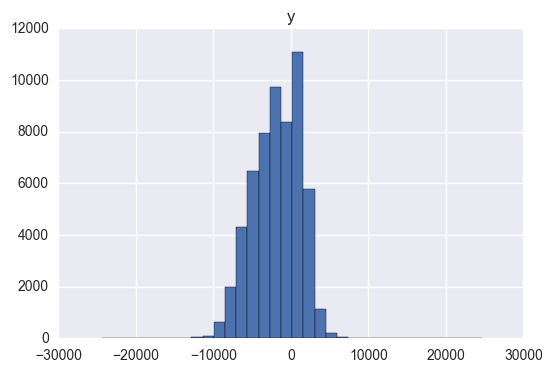

In [24]:
well_means.hist(column = 'y', bins = 35)

This distribution looks 'normal' or 'gaussian.  Let's plot the normal probability distribution along with the frequency of loads

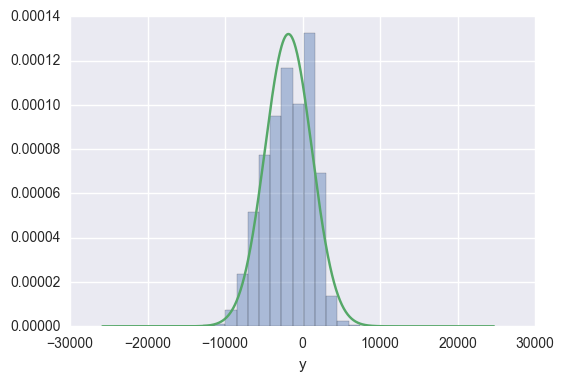

In [25]:
sns.distplot(well_means.y, norm_hist = True, bins = 35, kde = False)
x = np.linspace(min(well_means.y),max(well_means.y),1000)
y = norm.pdf(x, loc=np.mean(well_means.y), scale=np.std(well_means.y))    # for example
plt.plot(x,y)

## Assuming Gaussian Distribution

We can estimate the probability of finding a well with a mean load in a given range.  For example, the probability of finding a well whose mean load is greater than zero is given by:

In [26]:
y_mean = np.mean(well_means.y)
y_std = np.std(well_means.y)

In [27]:
y_mean, y_std

(-1832.019077852443, 3021.8343482962064)

In [28]:
y1 = 0

## One sample z-test
<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/3001169229a7ea675bf160036217bbb4572ef07d' align = left>  

In [29]:
#We can reformulate the question as "How many standard deviations away is this number from the mean?"
z = (y_mean - y1)/y_std
#Then we find the area under the normal pdf curve from z to infinite.  The integral of pdf is cdf
#(cumulative distribution function)
norm.cdf(z)

0.27217086171525362

# Towards Hypothesis Testing
Let's say we want to calculate the mean well load, but we can't afford to sample every well so we sample a few and average.  We might expect that if we repeated this experiment, sometimes we would be a little high and sometimes a little low.  On average (average of average, I know it gets confusing) would be the population mean.  Our high averages would balance our low averages.  

We might also suspect that, the more samples we have, the closer are estimate would be to the actual population mean.  Let's do an experiment where we randomly sample the wells with different sample sizes and then plot the distribution of means.

## Try different sample sizes 'size' and see how the samples get closer to the population mean

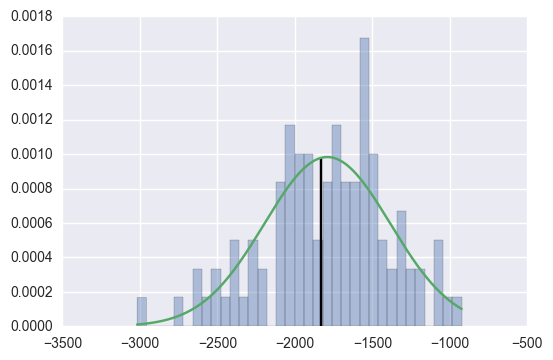

In [30]:
size = 50
means = []
for i in range(100):
    means.append(np.mean(np.random.choice(well_means.y, size, replace = True)))
    
sns.distplot(means, norm_hist = True, bins = 35, kde = False)
x = np.linspace(min(means),max(means),1000)
y = norm.pdf(x, loc=np.mean(means), scale=np.std(means))    # for example
plt.plot(x,y)
plt.vlines(y_mean, 0, max(y))

Using the one sample z test formula formula we can calculate the probability of a sample mean being different than the population mean.  We know from above the population mean and std are:

In [31]:
y_mean, y_std

(-1832.019077852443, 3021.8343482962064)

if our sample size is 500 and sample mean is 0

In [32]:
n = 500
mu = 0

In [33]:
z = (y_mean - mu)*np.sqrt(n)/y_std
z

-13.556398935184095

In [34]:
p = norm.cdf(z)
p

3.6307213451527304e-42

#This is astronomically low p!  
So if we were to find 500 wells with a mean of zero from this population we would likely say these wells don't belong to this distribution.  If our null hypothesis was "nothing fishy here, these wells are just like all the others" we would reject the null hypothesis in favor of the alternative.  Usually the cutoff is = = .05 for a one-sided hypothesis test

## A closer look at Alabama and Dutch

In [35]:
test = well_means[(well_means.well == 'Dutch')]

In [36]:
n = len(test)
mu = np.mean(test.y)

In [37]:
n, mu

(88, -1509.3267996304623)

In [38]:
z = (y_mean - mu)*np.sqrt(n)/y_std
z

-1.0017497803604569

In [39]:
p = norm.cdf(z)
p

0.15823222873437065

## Question: What do we know about Dutch compared to the rest of the wells? 

# Box Plot
The "dots" at the end of the boxplot represent outliers. There are a number of different rules for determining if a point is an outlier, but the method that R and ggplot use is the "1.5 rule". If a data point is:

less than Q1 - 1.5*IQR
greater than Q3 + 1.5*IQR
then that point is classed as an "outlier". The line goes to the first data point before the "1.5" cut-off. Note: IQR = Q3 - Q1



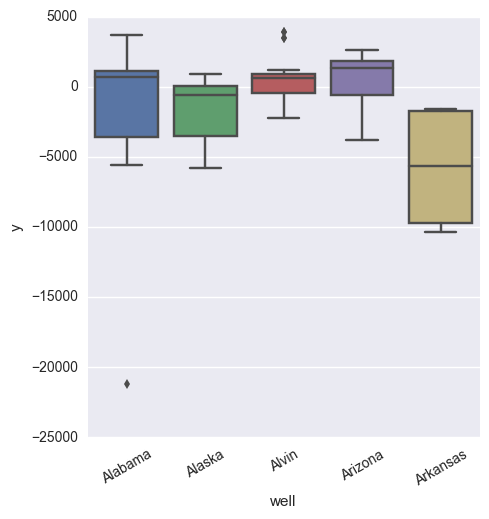

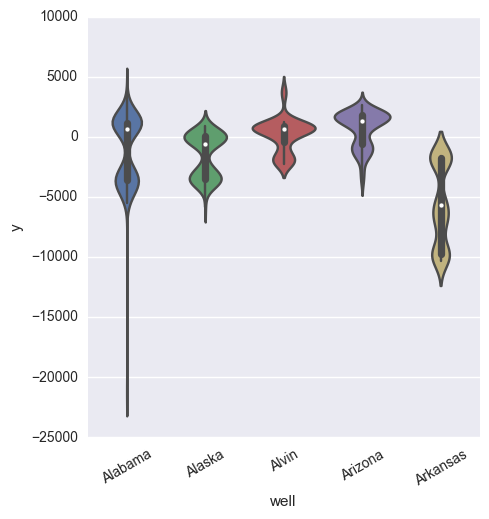

In [40]:
# Create a figure instance, and the two subplots
fig = plt.figure()
fg = sns.factorplot(x='well', y='y', 
                        data=well_means.head(1000), 
                        kind='box',orient='vertical', size = 5)
fg.set_xticklabels(rotation=30)

fg = sns.factorplot(x='well', y='y', 
                        data=well_means.head(1000), 
                        kind='violin',orient='vertical', size = 5)
fg.set_xticklabels(rotation=30)

plt.show()

In [41]:
import statsmodels.formula.api as smf

In [42]:
lst = ['Alabama','Alaska','Alvin','Arizona','Arkansas']
subsets = []
for well in lst:
    subsets.append(well_means.well == well)

In [43]:
y = well_means[subsets[0]].y
x = pd.Float64Index(well_means[subsets[0]].date_date)/1e18
#x = pd.Series(well_means[subsets[0]].date_date)

In [44]:
import statsmodels.api as sm

In [45]:
# Fit regression model (using the natural log of one of the regressors)
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()

# Inspect the results
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     321.3
Date:                Fri, 10 Feb 2017   Prob (F-statistic):           1.07e-43
Time:                        12:35:18   Log-Likelihood:                -1826.4
No. Observations:                 205   AIC:                             3657.
Df Residuals:                     203   BIC:                             3664.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -2.78e+05   1.54e+04    -17.998      0.0

# What do these values mean?

const?  
x1?  
R-squared?  

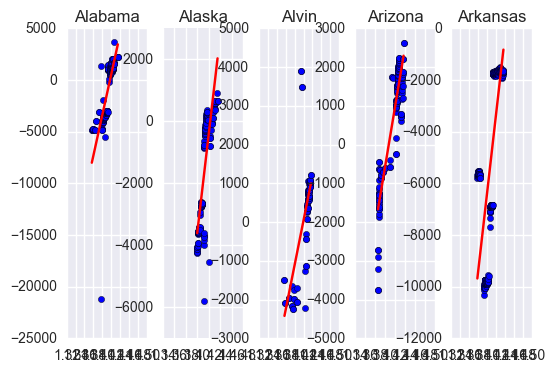

In [46]:
fig, axs = plt.subplots(1,len(lst))

axs = axs.ravel()
for i, well in enumerate(lst):
    y = well_means[subsets[i]].y
    date = well_means[subsets[i]].date_date
    x = pd.Float64Index(date)/1e18
    X = sm.add_constant(x)
    results = sm.OLS(y, X).fit()
    b = results.params[0]
    m = results.params[1]
    y_pred = m*x + b

    axs[i].scatter(x, y)
    axs[i].plot(x, y_pred, c = 'r')
    axs[i].set_title(well)
    #plt.setp(labels, rotation=90)
    #plt.xticks(date)
    #plt.title(well)
    #plt.show()

What's happening to the average well load over time?  Any idea why?  Need more data?  We fit a straight line.  Is this a good approximation?  We should like at the "residuals"  the difference between the actual point and the fit to see.

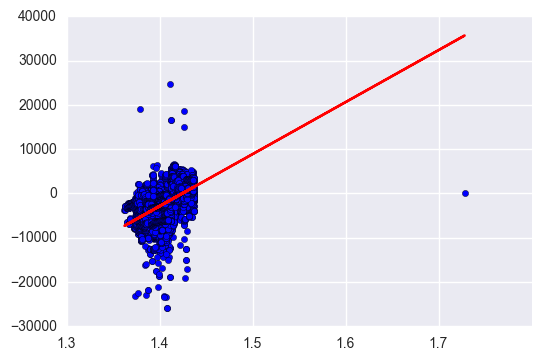

In [47]:
#Overall

y = well_means.y
x = pd.Float64Index(well_means.date_date)/1e18
# Fit regression model (using the natural log of one of the regressors)
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
b = results.params[0]
m = results.params[1]
y_pred = m*x + b
plt.scatter(x, y)
plt.plot(x, y_pred, c = 'r')

In [48]:
np.max(well_means.date_date)

Timestamp('2024-10-04 05:16:23')

In [49]:
#lets remove that weird date
well_means = well_means[well_means.date_date != np.max(well_means.date_date)]

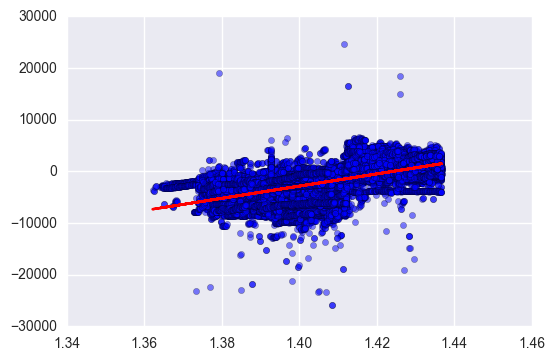

In [50]:
#Overall

y = well_means.y
x = pd.Float64Index(well_means.date_date)/1e18
# Fit regression model (using the natural log of one of the regressors)
X = sm.add_constant(x)
results = sm.OLS(y, X).fit()
b = results.params[0]
m = results.params[1]
y_pred = m*x + b
plt.scatter(x, y, alpha = .5)
plt.plot(x, y_pred, c = 'r')

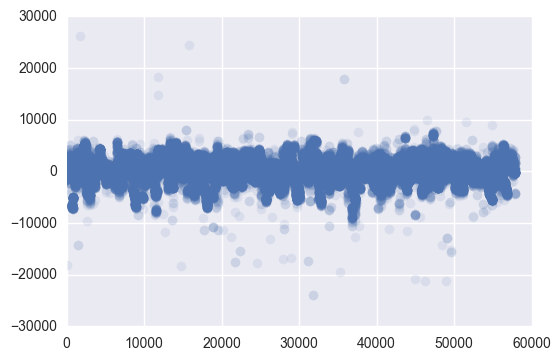

In [51]:
plt.plot(results.resid, 'o', alpha = .1)

#Notice the spread is uniform.  Not heterskedastic

http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html

<img src="http://www.sageoiltools.com/products/Dyno%20Card%20Shapes%202011%20small.jpg">

## Let's create a helper function for plotting dynamometer cards

In [52]:
import colorsys
def plot_dynamo(df, qty = 10, title = 'title'):
    '''
    Input:
        df is a dataframe with well, date_date, and x, y locations for dynamometer plot
        column names must match the above format
        qty is the number of dates to look at
        title is title
    Output: plot of dynamometer cards by date
    '''
    

    fig, ax = plt.subplots(1, 1)
    # find unique dates in dataframe
    dates = np.unique(df.date_date)
    N = len(dates[range(qty)])
    HSV_tuples = [(x*1.0/N, x*1.0/N, x*1.0/N) for x in range(N+1)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    for i, d in enumerate(dates):
        if i > qty:
            break
        #subset dataframe to a date, d
        tmp = df[df.date_date == d]
        #plot the dynamometer for that date.
        ax.plot(tmp.x,tmp.y, c = RGB_tuples[i])
    plt.title(title)
    

# Let's look at a well

In [53]:
alabama = mydata[mydata.well == 'Alabama']

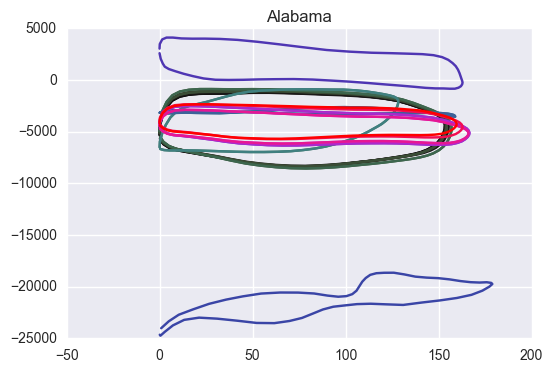

In [54]:
plot_dynamo(alabama, qty = 20, title = 'Alabama')

# Discussion: 
What can we say about these plots?  One of these things is not like the other...

# Dimensionality Reduction

Each well on each date has 60 sample points taken in order.  Each point has an x and y dimension.  If we want to compare well performance we can aggregate the data as we did in the previous examples and compare the mean loads of wells on different days, but what if we wanted to say more?  We know that engineers determine the health of a well based on the SHAPE of the plot.  How can we compare, quantitatively the shapes of these plots to one another?

We know all of these plots follow a similar pattern.  They move around in a cycle.  Each sample is successive in time, so there is a first, second... 60th sample for each well on each date.  What if we compared each well's nth sample to each other?  How should we transform the data to do this?

# Data Transformation: Pivot

In [55]:
mydata.head()

,well,date,idx,x,y,date_date
0,Alabama,8/16/2013 1:55:22 AM,1,0.000740,-5327.236980,2013-08-16 01:55:22
1,Alabama,8/16/2013 1:55:22 AM,2,0.155958,-4476.758361,2013-08-16 01:55:22
2,Alabama,8/16/2013 1:55:22 AM,3,1.536036,-3475.778052,2013-08-16 01:55:22
3,Alabama,8/16/2013 1:55:22 AM,4,3.779102,-2636.548613,2013-08-16 01:55:22
4,Alabama,8/16/2013 1:55:22 AM,5,6.817062,-1999.545532,2013-08-16 01:55:22


In [56]:
'''
Lets drop the string-date
'''
mydata.drop('date', inplace = True, axis = 1)

In [57]:
'''
Create a new multi-index that is composed of well, date_date, and idx
'''
index = pd.MultiIndex.from_tuples(list(zip(*[mydata.well,
                    mydata.date_date,
                    mydata.idx])), names=['well', 'date_date','idx'])

In [58]:
'''
Now we'll reset the index of mydata with this multi-index.  This is like doing a group by in SQL
'''
mydata.index = index
mydata.drop(['well','idx','date_date'], inplace = True, axis = 1)

In [59]:
mydata.head()

x            y
well    date_date           idx                       
Alabama 2013-08-16 01:55:22 1    0.000740 -5327.236980
                            2    0.155958 -4476.758361
                            3    1.536036 -3475.778052
                            4    3.779102 -2636.548613
                            5    6.817062 -1999.545532

In [60]:
#example.pivot(columns='frame',values='x')
mydata_piv=mydata.unstack()

In [61]:
mydata_piv.head()

x                                          \
idx                                1         2         3         4         5    
well    date_date                                                               
Alabama 2013-08-16 01:55:22  0.000740  0.155958  1.536036  3.779102  6.817062   
        2013-08-16 23:49:23  0.000740  0.155958  1.536036  3.779102  6.817062   
        2013-09-03 00:17:00 -0.001119  0.155196  1.551999  3.833990  6.943099   
        2013-09-06 09:38:47 -0.000845  0.152832  1.528256  3.758398  6.777739   
        2013-09-06 16:13:14 -0.000845  0.152832  1.528256  3.758398  6.777739   

                                                                         \
idx                                 6          7          8          9    
well    date_date                                                         
Alabama 2013-08-16 01:55:22  10.731165  15.530883  21.092574  27.242844   
        2013-08-16 23:49:23  10.731165  15.530883  21.092574  27.242844   
        2013-09-03 00:17:00  10.965199  15.911108  21.653168  28.014554   
        2013-09-06 09:38:47  10.668115  15.444336  20.985934  27.126929   
        2013-09-06 16:13:14  10.668115  15.444336  20.985934  27.126929   

                                           ...                 y               \
idx                                 10     ...                51           52   
well    date_date                          ...                                  
Alabama 2013-08-16 01:55:22  33.866955     ...      -7995.121921 -7746.026979   
        2013-08-16 23:49:23  33.866955     ...      -7995.121921 -7746.026979   
        2013-09-03 00:17:00  34.876321     ...      -7910.082878 -7653.229517   
        2013-09-06 09:38:47  33.757400     ...      -7988.549524 -7727.405718   
        2013-09-06 16:13:14  33.757400     ...      -7988.549524 -7727.405718   

                                                                    \
idx                                   53           54           55   
well    date_date                                                    
Alabama 2013-08-16 01:55:22 -7485.599933 -7280.155037 -7099.039466   
        2013-08-16 23:49:23 -7485.599933 -7280.155037 -7099.039466   
        2013-09-03 00:17:00 -7383.678852 -7171.350237 -6983.406693   
        2013-09-06 09:38:47 -7454.861095 -7238.673674 -7047.548676   
        2013-09-06 16:13:14 -7454.861095 -7238.673674 -7047.548676   

                                                                    \
idx                                   56           57           58   
well    date_date                                                    
Alabama 2013-08-16 01:55:22 -6939.133799 -6789.504263 -6570.492488   
        2013-08-16 23:49:23 -6939.133799 -6789.504263 -6570.492488   
        2013-09-03 00:17:00 -6817.602155 -6661.875376 -6433.119702   
        2013-09-06 09:38:47 -6876.871832 -6715.280975 -6481.500865   
        2013-09-06 16:13:14 -6876.871832 -6715.280975 -6481.500865   

                                                       
idx                                   59           60  
well    date_date                                      
Alabama 2013-08-16 01:55:22 -6228.391545 -5806.149383  
        2013-08-16 23:49:23 -6228.391545 -5806.149383  
        2013-09-03 00:17:00 -6076.560659 -5639.931748  
        2013-09-06 09:38:47 -6119.148310 -5674.980384  
        2013-09-06 16:13:14 -6119.148310 -5674.980384  

[5 rows x 120 columns]

# Do we really need this many points?

Dynameter plots are, for the most parts parallelograms 

<img src = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Parallelogram.svg/255px-Parallelogram.svg.png' align = left>


If you had a bunch of parallelograms, and they all started at the same position 'D'.  How much data do we really need to describe how different they are?  Do we need all 60 points?  Do we need 20?  Intuitively how many points do you think we need?

# Principal Component Analysis (PSA)

"Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables"

In our case we have a set of columns.  Each column is the nth point in our dynamometer plot.  There is an x column and y column for each nth point for a total of 120 columns.  

https://en.wikipedia.org/wiki/Principal_component_analysis

In [62]:
# Let's start by crunching the data down to 10 variables
from sklearn.preprocessing import StandardScaler
Scale = StandardScaler(with_std=False, with_mean=False)
df_cur_piv_scale = Scale.fit_transform(mydata_piv)

from sklearn.decomposition import PCA
pca = PCA(n_components=10)
#pca_fit = pca.fit(Data_6_scale)
df_pca=pca.fit_transform(df_cur_piv_scale)

In [63]:
pca_ev = pd.DataFrame(pca.explained_variance_ratio_)
pca_ev[1]= pca_ev.index + 1
pca_ev.columns = ['explained_var','component']

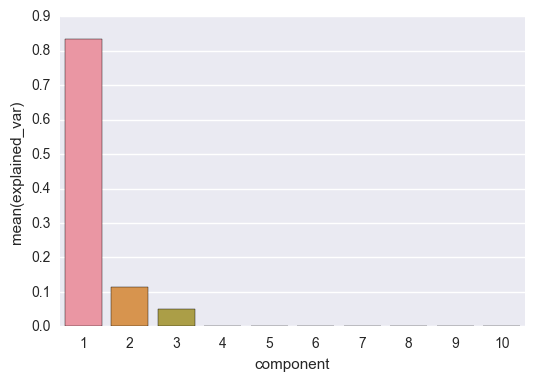

In [64]:
sns.barplot(x="component", y="explained_var", data=pca_ev)

This is a scree plot.  It shows that almost all of the variance in the data can be explained in only three variables.  Is this intuitive?  How many corners in a parallelogram?  If we say the first corner is always the same?

In [65]:
#Just keep first three components
PCA = pd.DataFrame(df_pca)[[0,1,2]]

In [66]:
PCA.index = mydata_piv.index

## Now we can locate each well in 3D space

In [67]:
AlabamaPCA = PCA.loc['Alabama']

In [68]:
AlabamaPCA.head()

,0,1,2
date_date,,,
2013-08-16 01:55:22,23076.544178,5974.275920,-2642.798394
2013-08-16 23:49:23,23076.544178,5974.275920,-2642.798394
2013-09-03 00:17:00,23167.694748,5483.845575,-3230.180084
2013-09-06 09:38:47,22490.602937,6350.976111,-3256.033200
2013-09-06 16:13:14,22490.602937,6350.976111,-3256.033200


In [69]:
color = AlabamaPCA.index

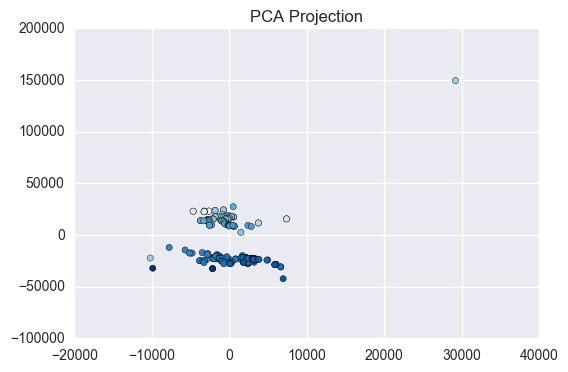

In [70]:
plt.scatter(AlabamaPCA[2],AlabamaPCA[0], c = color, cmap = 'Blues')
plt.title('PCA Projection')

In the reduced data set, the outlier dynamometer plot appears as a point away from the main cluster.  In this reduced dimensional space we can easily spot the bad wells or find groupings of similar wells.  This is also true for ML.  Our models will train faster and in some cases be more accurate (although this isn't categorically true) by operating in this abridged vector space.  As an exercise, you might try adding date labels to the plot.  But we can find that outlier and see what its dynamomoter plot looks like

In [71]:
AlabamaPCA[AlabamaPCA[2] > 20000]

,0,1,2
date_date,,,
2014-04-22 13:37:34,149293.688239,-1678.248804,29171.089001


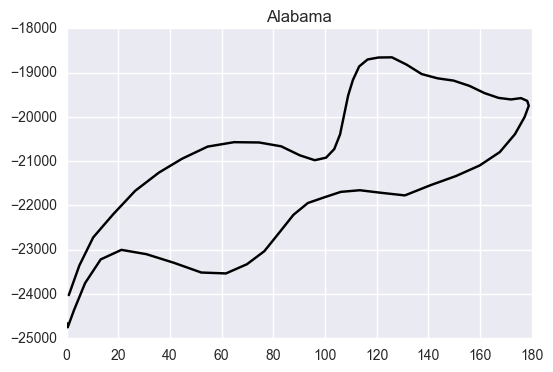

In [72]:
d = AlabamaPCA[AlabamaPCA[2] > 20000].index[0]
tmp = alabama[alabama.date_date == d]
plot_dynamo(tmp, qty = 1, title = 'Alabama')

## Clusters and Shapes

In another lab we clustered the plots.  Since the data set was scaled and centered to be of the same size and spread, and dimensions reduced, there is not much left to differentiate the plots besides shape.  Let's see if the plots in different clusters have different shapes

In [80]:

clusters.head()

,well,date,PC1,PC2,PC3,Assignments,DistancesToClusterCenter no.0,DistancesToClusterCenter no.1,DistancesToClusterCenter no.2,DistancesToClusterCenter no.3,...,DistancesToClusterCenter no.35,DistancesToClusterCenter no.36,DistancesToClusterCenter no.37,DistancesToClusterCenter no.38,DistancesToClusterCenter no.39,DistancesToClusterCenter no.40,DistancesToClusterCenter no.41,DistancesToClusterCenter no.42,DistancesToClusterCenter no.43,DistancesToClusterCenter no.44
0,Alabama,8/16/2013 1:55:22 AM,-8.243341,2.918071,2.023029,35,6.714860,51.268731,20.234037,103.460108,...,3.586196,18.726721,18.767351,19.583565,24.860455,31.841913,12.006251,16.855345,37.656028,12.293685
1,Alabama,8/16/2013 11:49:23 PM,-8.243341,2.918071,2.023029,35,6.714860,51.268731,20.234037,103.460108,...,3.586196,18.726721,18.767351,19.583565,24.860455,31.841913,12.006251,16.855345,37.656028,12.293685
2,Alabama,9/3/2013 12:17:00 AM,-8.495328,2.311737,2.154067,35,6.532590,51.391863,20.387094,102.817129,...,3.609677,18.968639,19.316435,19.535205,25.149660,31.937525,11.907671,16.960351,38.014414,12.030378
3,Alabama,9/6/2013 9:38:47 AM,-8.148383,2.731808,2.341957,35,6.693467,51.531961,20.148056,103.339129,...,3.872818,18.632032,18.854270,19.449607,24.780219,32.108457,12.192562,16.714817,38.024970,12.217932
4,Alabama,9/6/2013 4:13:14 PM,-8.148383,2.731808,2.341957,35,6.693467,51.531961,20.148056,103.339129,...,3.872818,18.632032,18.854270,19.449607,24.780219,32.108457,12.192562,16.714817,38.024970,12.217932


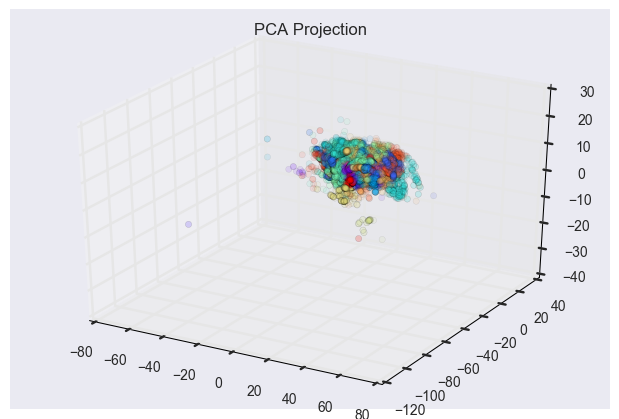

In [81]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(clusters['PC1'],clusters['PC2'], clusters['PC3'], 
           c = clusters['Assignments'], 
           cmap = 'rainbow',
           alpha = .1)
plt.title('PCA Projection')

## Plot of Wells in PC Space Colored by Cluster

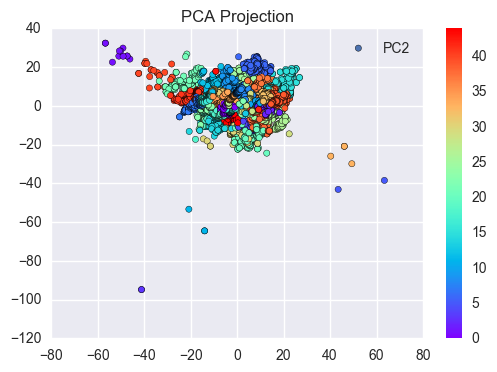

In [82]:
plt.scatter(clusters['PC1'],clusters['PC2'], c = clusters['Assignments'], cmap = 'rainbow')
plt.title('PCA Projection')
plt.legend()
plt.colorbar()

What might we guess about clusters of failed wells?  Healthy wells?  Are most wells healthy most of the time?

## For Reference: Dynamometer Shapes
<img src="http://www.sageoiltools.com/products/Dyno%20Card%20Shapes%202011%20small.jpg">

In [83]:
#Using a list comprension convert string date to datetime64 (This may take a few minutes)
clusters['date_date'] = [datetime.strptime(dt,'%m/%d/%Y %I:%M:%S %p') for dt in clusters.date]

In [84]:
clusters = clusters[['well','date_date','PC1','PC2','PC3','Assignments']]

In [85]:
mydata.reset_index(inplace = True)

In [86]:
#Here we join our cluster data onto our original data set
clusters_nw = pd.merge(mydata,clusters,on=['well', 'date_date'])

In [87]:
#Let's pick a cluster
cluster_fortyfour = clusters_nw[clusters_nw.Assignments == 44]

In [88]:
def plot_dynamo(df, qty = 10, title = 'title'):
    '''
    Input:
        df is a dataframe with wells, dates, and x, y locations for dynamometer plot
        qty is the number of dates to look at
        title is title
    Output: plot of dynamometer cards  
    '''
    
    fig, ax = plt.subplots(1, 1)
    dates = np.unique(df.date_date)
    for i, d in enumerate(dates):
        if i > qty:
            break
        tmp = df[df.date_date == d]
        ax.plot(tmp.x,tmp.y)
    plt.title(title)
    

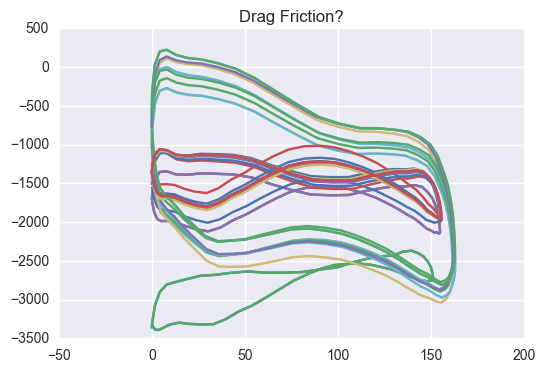

In [89]:
plot_dynamo(cluster_fortyfour, 20, 'Drag Friction?')

In [90]:
cluster_one = clusters_nw[clusters_nw.Assignments == 0]

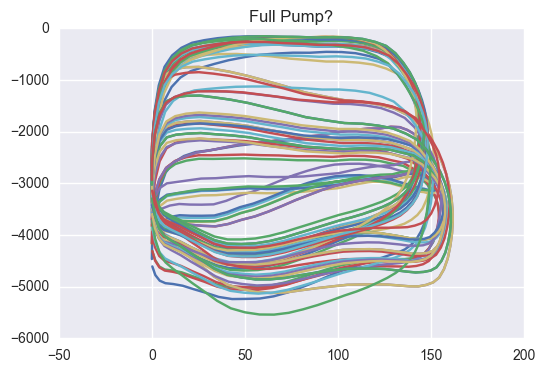

In [91]:
plot_dynamo(cluster_one, 50, 'Full Pump?')

# Remaining Useful Life
## Calculate Distance to next failure

* Find wells that have experienced a failure 44.  Friction Drag
* For each well calculate distance to failure

In [92]:
#Find All wells that have a cluster 44 dynamometer
Fails = pd.DataFrame(np.unique(clusters[clusters.Assignments == 44]['well']))
Fails.columns = ['well']
Cluster_44 = pd.merge(Fails, clusters, on = 'well')
Cluster_44.head()

,well,date_date,PC1,PC2,PC3,Assignments
0,Alabama,2013-08-16 01:55:22,-8.243341,2.918071,2.023029,35
1,Alabama,2013-08-16 23:49:23,-8.243341,2.918071,2.023029,35
2,Alabama,2013-09-03 00:17:00,-8.495328,2.311737,2.154067,35
3,Alabama,2013-09-06 09:38:47,-8.148383,2.731808,2.341957,35
4,Alabama,2013-09-06 16:13:14,-8.148383,2.731808,2.341957,35


In [93]:
#Find first date that each well experienced a cluster 44 plot
Well_44 = Cluster_44[Cluster_44.Assignments == 44][['well','date_date']].groupby('well').min().reset_index()

In [94]:
Well_44.head()

,well,date_date
0,Alabama,2014-02-23 01:35:02
1,Arizona,2013-12-05 06:10:47
2,Arkansas,2014-10-03 21:32:42
3,Bagel,2015-01-28 04:11:59
4,Balou,2014-01-10 07:03:30


In [95]:
#Join on well and subtract the dates.  This is the time-to-failure
MyRUL = pd.merge(clusters, Well_44, on = 'well')

In [96]:
MyRUL.head()

,well,date_date_x,PC1,PC2,PC3,Assignments,date_date_y
0,Alabama,2013-08-16 01:55:22,-8.243341,2.918071,2.023029,35,2014-02-23 01:35:02
1,Alabama,2013-08-16 23:49:23,-8.243341,2.918071,2.023029,35,2014-02-23 01:35:02
2,Alabama,2013-09-03 00:17:00,-8.495328,2.311737,2.154067,35,2014-02-23 01:35:02
3,Alabama,2013-09-06 09:38:47,-8.148383,2.731808,2.341957,35,2014-02-23 01:35:02
4,Alabama,2013-09-06 16:13:14,-8.148383,2.731808,2.341957,35,2014-02-23 01:35:02


In [97]:
MyRUL['RUL'] = (MyRUL.date_date_y - MyRUL.date_date_x)/np.timedelta64(1,'D')

In [98]:
# Only keep positive values?  Only interested in time to failure, not time from failure
# An improvement would be to not only find time to first failure but all failures.  Bonus Exercise

In [99]:
MyRUL = MyRUL[MyRUL.RUL >= 0]

In [100]:
MyRUL.head()

,well,date_date_x,PC1,PC2,PC3,Assignments,date_date_y,RUL
0,Alabama,2013-08-16 01:55:22,-8.243341,2.918071,2.023029,35,2014-02-23 01:35:02,190.985880
1,Alabama,2013-08-16 23:49:23,-8.243341,2.918071,2.023029,35,2014-02-23 01:35:02,190.073368
2,Alabama,2013-09-03 00:17:00,-8.495328,2.311737,2.154067,35,2014-02-23 01:35:02,173.054190
3,Alabama,2013-09-06 09:38:47,-8.148383,2.731808,2.341957,35,2014-02-23 01:35:02,169.664062
4,Alabama,2013-09-06 16:13:14,-8.148383,2.731808,2.341957,35,2014-02-23 01:35:02,169.390139


In [101]:
# if we want to upload data back to AML
# upload.dataset(RUL, ws, 'MyRUL', description = "")

## Counts Tend to follow a Poisson Distribution
Another way of looking at this is to say, "how many wells will fail in the next n days?"  
https://en.wikipedia.org/wiki/Poisson_distribution

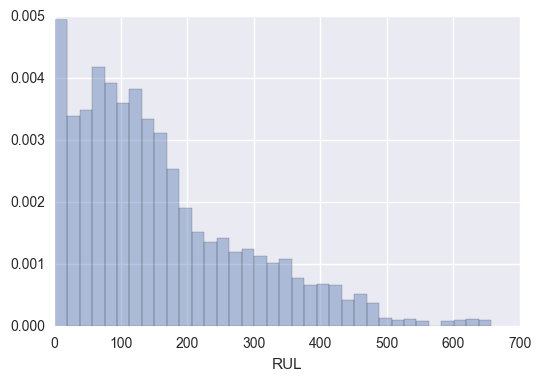

In [102]:
sns.distplot(MyRUL.RUL, norm_hist = True, bins = 35, kde = False)

What can we say about this plot?  Is this a good use-case for Poisson Regression.  Non-parametric learner?  Can we try both?